In [540]:
import pandas as pd
from tqdm import tqdm
from database.strategy import Strategy
from database.market import Market
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import numpy as np
import statistics
from sklearn.preprocessing import normalize

In [541]:
strat_db = Strategy("unity")
market = Market()
suffix = "headless"

In [542]:
market.connect()
sp5 = market.retrieve_data("sp500")
market.close()

In [543]:
strat_db.connect()
tse = strat_db.retrieve_data("{}_epochs".format(suffix))
strat_db.close()
bench = pd.read_csv("GSPC.csv")

In [544]:
list(tse.columns)

['_id', 'epoch', 'dataset', 'dr', 'value_setting', 'hpr', 'delta_column']

In [545]:
strat_db.connect()
analysis = []
start = datetime(2018,1,1)
end = datetime(2021,1,1)
cash = 100
seats = len(sp5["GICS Sector"].unique())
for epoch in tqdm(tse["epoch"].unique()):
    epoch_dict = tse[tse["epoch"]==epoch].iloc[0]
    trades = strat_db.retrieve_data("{}_{}".format(suffix,epoch))
    trades = trades[(trades["date"]>=start) & (trades["sell_date"] <= end)]
    if trades.index.size < 1:
        print(epoch,trades.index.size)
        continue
    else:
        for industry in trades["industry"].unique():
            initial = float(cash/(seats))
            seat_trades = trades[trades["industry"] == industry]
            seat_trades.sort_values("sell_date",inplace=True)
            if seat_trades.index.size > 0:
                for delta in seat_trades["sell_delta"]:
                    initial = initial * (1 + delta)
                stg = seat_trades.groupby("industry").mean().reset_index()[["adjclose","sell_price","industry","sell_delta"]]
                for col in list(tse.columns):
                    if col == "__id":
                        continue
                    else:
                        stg[col] = epoch_dict[col]
                stg["initial_pv"] = initial
                stg["trades"] = seat_trades.index.size
                stg["industry"] = industry
                stg["winrate"] = seat_trades[seat_trades["sell_delta"] > 0].index.size / seat_trades.index.size
                initial = float(cash/(seats))
                analysis.append(stg)
                continue
            else:
                stg["initial_pv"] = initial
                stg["trades"] = 0
                stg["industry"] = industry
                stg["winrate"] = 0
                initial = float(cash/(seats))
                analysis.append(stg)
                continue
strat_db.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.63it/s]


In [546]:
a = pd.concat(analysis)

In [547]:
metric = "initial_pv"
index_cols = list(tse.columns)
index_cols.remove("_id")
tsmc = ""
seats = len(sp5["GICS Sector"].unique())
apt = a.pivot_table(index=index_cols,columns="industry",values=metric)
if metric == "winrate":
    apt[metric] = [statistics.mean([row[1][i] for i in range(seats) if not np.isnan(row[1][i])]) for row in apt.iterrows()]
else:
    apt.fillna(cash/(seats),inplace=True)
    apt[metric] = [sum([row[1][i] for i in sp5["GICS Sector"].unique() if i in apt.columns]) for row in apt.iterrows()]
    apt["perf"] = 1 + (apt[metric] - cash) / cash
apt.reset_index(inplace=True)

In [548]:
apt.sort_values(metric,ascending=False)

industry,epoch,dataset,dr,value_setting,hpr,delta_column,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities,initial_pv,perf
2,2,pdr,0.09,True,7,100d,11.388491,5.306260,14.479129,58.977176,14.968599,12.444104,24.959172,10.080600,30.854563,6.005571,21.177882,210.641547,2.106415
0,0,pdr,0.03,True,7,100d,27.133657,3.222981,16.241616,14.912455,9.777805,30.445720,23.102170,12.505652,21.340601,15.068283,29.227481,202.978421,2.029784
9,9,pdr,0.03,True,14,7d,12.992663,53.395077,11.563894,5.875850,20.692041,15.881864,8.563967,8.358460,11.074372,20.143623,27.441355,195.983167,1.959832
10,10,pdr,0.06,True,14,7d,12.992663,53.395077,11.563894,5.875850,20.692041,15.881864,8.563967,8.358460,11.074372,20.143623,27.441355,195.983167,1.959832
11,11,pdr,0.09,True,14,7d,12.992663,53.395077,11.563894,5.875850,20.692041,15.881864,8.563967,8.358460,11.074372,20.143623,27.441355,195.983167,1.959832
7,7,pdr,0.06,True,14,100d,32.776306,9.425153,18.780711,7.309381,7.861694,11.515431,20.414461,21.517857,21.752961,5.812768,15.805323,172.972046,1.729720
1,1,pdr,0.06,True,7,100d,4.715355,1.668451,15.147404,38.265677,12.999085,15.247603,8.951100,12.938791,21.235848,7.788995,19.791693,158.750003,1.587500
6,6,pdr,0.03,True,14,100d,7.908670,4.274815,18.339478,8.956925,6.690083,20.632692,24.891081,15.793740,19.748763,8.879979,17.230351,153.346578,1.533466
8,8,pdr,0.09,True,14,100d,7.333516,13.980294,23.110008,9.703725,6.828108,16.303426,11.460200,24.341927,15.701157,5.800774,12.824178,147.387312,1.473873
3,3,pdr,0.03,True,7,7d,20.603678,19.498744,9.126912,7.607346,5.149635,16.219126,15.504165,5.826012,13.349994,12.366347,11.225723,136.477681,1.364777


In [549]:
if tsmc == "industry":
    bf = []
    for industry in apt["industry"].unique():
        industry_apt = apt[apt["industry"] == industry].sort_values(metric,ascending=False).head(1)
        bf.append(industry_apt)
    bff = pd.concat(bf)
    bff.sort_values(metric,ascending=False)

In [550]:
strat_db.connect()
epoch = apt.sort_values(metric,ascending=False).reset_index().iloc[0]["epoch"]
analysis = []
trades = strat_db.retrieve_data("{}_{}".format(suffix,int(epoch)))
trades = trades[(trades["date"]>=start) & (trades["sell_date"] <= end)]
strat_db.close()

In [551]:
print("trades:",len(trades))
top_epoch = tse[tse["epoch"]==epoch]
for col in top_epoch.columns:
    print(col,":",top_epoch[col].item())

trades: 1124
_id : 6075c1e11383fbba0223b1b9
epoch : 2
dataset : pdr
dr : 0.09
value_setting : True
hpr : 7
delta_column : 100d


In [552]:
trades.sort_values("date")
trades["date"] = pd.to_datetime(trades["date"])
trades["sell_date"] = pd.to_datetime(trades["sell_date"])
dta = "date"
trades["week"] = [x.week for x in trades[dta]]
trades["quarter"] = [x.quarter for x in trades[dta]]
trades["dayofWeek"] = [x.weekday() for x in trades[dta]]
trades["month"] = [x.month for x in trades[dta]]
trades["year"] = [x.year for x in trades[dta]]
trades = trades[trades["sell_date"] <= end]

In [553]:
bench

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-04,1994.010010,2009.130005,1986.770020,1999.989990,1999.989990,6049930000
1,2016-03-07,1996.109985,2006.119995,1989.380005,2001.760010,2001.760010,4968180000
2,2016-03-08,1996.880005,1996.880005,1977.430054,1979.260010,1979.260010,4641650000
3,2016-03-09,1981.439941,1992.689941,1979.839966,1989.260010,1989.260010,4038120000
4,2016-03-10,1990.969971,2005.079956,1969.250000,1989.569946,1989.569946,4376790000
...,...,...,...,...,...,...,...
1253,2021-02-25,3915.800049,3925.020020,3814.040039,3829.340088,3829.340088,6513060000
1254,2021-02-26,3839.659912,3861.080078,3789.540039,3811.149902,3811.149902,6512950000
1255,2021-03-01,3842.510010,3914.500000,3842.510010,3901.820068,3901.820068,5071540000
1256,2021-03-02,3903.639893,3906.409912,3868.570068,3870.290039,3870.290039,5493690000


In [554]:
prices = trades
daily = prices.groupby(["year","dayofWeek"]).mean().reset_index()
quarterly = prices.groupby(["year","quarter"]).mean().reset_index()
monthly = prices.groupby(["year","month"]).mean().reset_index()
weekly = prices.groupby(["year","week"]).mean().reset_index()

In [555]:
timelines= []
for industry in sp5["GICS Sector"].unique():
    timeline = []
    initial = float(cash/(seats + 1))
    st = prices[prices["industry"] == industry]
    st.sort_values("sell_date",inplace=True)
    if st.index.size > 0:
        for row in st.iterrows():
            initial = initial * (1+row[1]["sell_delta"])
            timeline.append({"date":row[1]["sell_date"],"industry":industry,"pv":initial})
        timelines.append(pd.DataFrame(timeline))
        initial = float(100/(seats + 1))
        continue
    else:
        continue
ts = pd.concat(timelines)

In [556]:
tspivot = ts.pivot_table(index="date",columns="industry",values="pv")
tspivot.iloc[0].fillna(100/(seats),inplace=True)

In [557]:
cleaned = []
for i in range(tspivot.index.size):
    row = tspivot.iloc[i]
    for col in tspivot.columns:
        if col == "date":
            continue
        else:
            col_val = row[col].item()
            if math.isnan(col_val):
                row[col] = tspivot.iloc[i-1][col].item()
            else:
                continue
    cleaned.append(row)

In [558]:
tspivot = pd.DataFrame(cleaned)

In [559]:
for i in range(seats):
    if i not in tspivot.columns:
        tspivot[i] = 100/(seats +1)

In [560]:
# tspivot = ts.pivot_table(index="date",columns="seat",values="pv")
tspivot["pv"] = [sum([row[1][i] for i in sp5["GICS Sector"].unique() if i in tspivot.columns]) for row in tspivot.iterrows()]
tspivot.reset_index(inplace=True)

In [561]:
tspivot

industry,index,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,...,2,3,4,5,6,7,8,9,10,pv
0,2018-01-10,9.090909,8.751618,8.442836,9.090909,8.540219,8.505521,8.577362,8.556913,9.090909,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,94.858434
1,2018-01-11,8.715638,8.751618,8.442836,9.090909,8.540219,8.505521,8.577362,8.556913,9.090909,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,94.483163
2,2018-01-18,8.715638,8.751618,8.442836,9.090909,8.540219,8.505521,8.577362,8.556913,8.422355,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,93.814609
3,2018-01-19,8.715638,8.751618,8.630403,9.090909,8.454535,8.423242,8.577362,8.153115,8.422355,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,93.542812
4,2018-01-23,8.715638,9.055182,8.630403,9.090909,8.454535,8.423242,8.577362,8.153115,8.422355,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,93.846375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,2020-11-23,9.231392,4.442043,13.272535,54.062411,13.721216,10.313829,22.879241,9.240550,28.283349,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,188.611896
474,2020-11-24,10.439450,4.442043,13.272535,54.062411,13.721216,10.313829,22.879241,9.240550,28.283349,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,189.819954
475,2020-12-04,10.439450,4.442043,13.272535,54.062411,13.721216,11.407096,22.879241,9.240550,28.283349,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,190.913221
476,2020-12-15,10.439450,4.864072,13.272535,54.062411,13.721216,11.407096,22.879241,9.240550,28.283349,...,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,8.333333,191.335249


In [562]:
pvs = [100]
current_pv = 100
for i in range(1,tspivot.index.size):
    replacement = current_pv/seats
    current_date = tspivot.iloc[i].fillna(replacement)
    current_pv =sum([current_date[c] for c in sp5["GICS Sector"].unique() if c in tspivot.columns])
    pvs.append(current_pv)
tspivot["pv"] = pvs 

In [563]:
bench.rename(columns={"Date":"index","Adj Close":"bench"},inplace=True)
bench["index"]= pd.to_datetime(bench["index"])
bench = bench[(bench["index"]>=start) & (bench["index"]<=end)]
bench["bench"] = (bench["bench"] - bench["bench"].iloc[0]) / bench["bench"].iloc[0]
tspivot["pv"] = (tspivot["pv"] - 100) / 100

In [564]:
tspivot = tspivot.merge(bench,on="index",how="left")

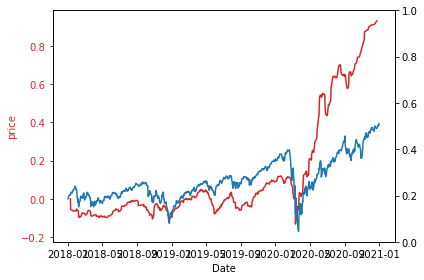

<Figure size 2304x1296 with 0 Axes>

In [565]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('price', color=color)
ax1.plot(tspivot["index"], tspivot["pv"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(bench["index"],bench["bench"], color=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.figure(figsize=(32,18))
fig.tight_layout()

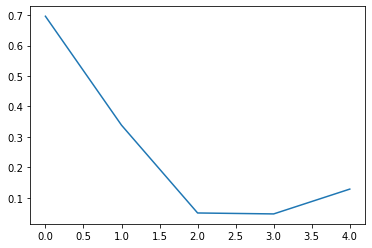

In [566]:
normalized = []
for year in daily["year"].unique():
    subset = daily[daily["year"] == year]
    subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
    normalized.append(subset)
grouped = pd.concat(normalized).groupby("dayofWeek").mean().reset_index()
plt.plot(grouped["sell_delta"])

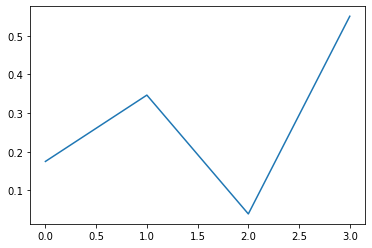

In [567]:
normalized = []
for year in quarterly["year"].unique():
    try:
        subset = quarterly[quarterly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("quarter").mean().reset_index()
plt.plot(grouped["sell_delta"])

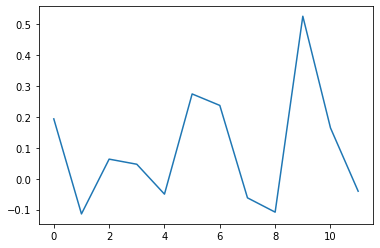

In [568]:
normalized = []
for year in monthly["year"].unique():
    try:
        subset = monthly[monthly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("month").mean().reset_index()
plt.plot(grouped["sell_delta"])

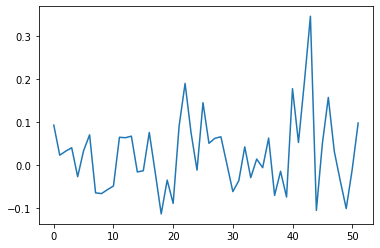

In [569]:
normalized = []
for year in weekly["year"].unique():
    try:
        subset = weekly[weekly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("week").mean().reset_index()
plt.plot(grouped["sell_delta"])

In [570]:
ntrades = []
trades.sort_values("date",inplace=True)
for year in trades["year"].unique():
    subset = trades[(trades["year"] == year)]
    for week in subset["week"].unique():
        ntrades.append(len(subset[(subset["week"] == week)]))
weekly["ntrades"]= ntrades

In [571]:
sp5.columns

Index(['_id', 'Symbol', 'Security', 'SEC filings', 'GICS Sector',
       'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK',
       'Founded'],
      dtype='object')

In [572]:
trades["trade"] = 1

In [573]:
sp5["ticker"] = sp5["Symbol"]

In [574]:
ticker_yearly = trades.groupby(["year","ticker"]).sum().reset_index().merge(sp5, on="ticker",how="left")
yp = []
for year in ticker_yearly["year"].unique():
    yp.append(ticker_yearly[ticker_yearly["year"] == year].sort_values("sell_delta",ascending=False))
yp_final = pd.concat(yp)
yp_final["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in yp_final.iterrows()]
yp_final.sort_values("aggregate_gain",ascending=False)[["year","Security","ticker","GICS Sector","sell_delta","trade","aggregate_gain"]].head(50)

,year,Security,ticker,GICS Sector,sell_delta,trade,aggregate_gain
434,2020,United Airlines Holdings,UAL,Industrials,0.568398,7,0.727196
337,2020,Carnival Corp.,CCL,Consumer Discretionary,0.573443,4,0.708965
414,2020,Occidental Petroleum,OXY,Energy,0.533931,9,0.679830
326,2020,Apache Corporation,APA,Energy,0.545648,3,0.650909
342,2020,CenterPoint Energy,CNP,Utilities,0.509980,8,0.639489
323,2020,AMC,AMC,Communication Services,0.461906,7,0.564091
314,2020,American Airlines Group,AAL,Industrials,0.454913,5,0.545572
397,2020,Lincoln National,LNC,Financials,0.421709,4,0.493209
448,2020,Xerox,XRX,Information Technology,0.404491,6,0.479109
426,2020,Sysco Corp.,SYY,Consumer Staples,0.256177,3,0.278675


In [575]:
ticker_analysis = trades.groupby("ticker").sum().reset_index().merge(sp5, on="ticker",how="left")
ticker_analysis["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in ticker_analysis.iterrows()]
ticker_analysis["average_gain"] = [(row[1]["sell_delta"] / row[1]["trade"]) for row in ticker_analysis.iterrows()]
ticker_analysis.sort_values("aggregate_gain",ascending=False)[["Security","ticker","sell_delta","trade","average_gain"]].head(50)

,Security,ticker,sell_delta,trade,average_gain
16,AMC,AMC,0.758995,15,0.050600
1,American Airlines Group,AAL,0.590883,16,0.036930
23,Apache Corporation,APA,0.602031,7,0.086004
59,CenterPoint Energy,CNP,0.587740,12,0.048978
267,United Airlines Holdings,UAL,0.568398,7,0.081200
48,Carnival Corp.,CCL,0.573443,4,0.143361
215,Occidental Petroleum,OXY,0.477421,11,0.043402
295,Xerox,XRX,0.438375,7,0.062625
170,Lincoln National,LNC,0.421709,4,0.105427
50,CF Industries Holdings Inc,CF,0.318923,7,0.045560


In [576]:
ticker_analysis = trades.merge(sp5, on="ticker",how="left").groupby("GICS Sector").sum().reset_index()
ticker_analysis["aggregate_gain"] = [(1+(row[1]["sell_delta"] / row[1]["trade"])) ** row[1]["trade"] - 1 for row in ticker_analysis.iterrows()]
ticker_analysis["average_gain"] = [(row[1]["sell_delta"] / row[1]["trade"]) for row in ticker_analysis.iterrows()]
ticker_analysis.sort_values("sell_delta",ascending=False)[["GICS Sector","sell_delta","trade","average_gain"]].head(50)

,GICS Sector,sell_delta,trade,average_gain
3,Energy,2.122181,103,0.020604
8,Materials,1.384751,99,0.013987
6,Industrials,1.326473,106,0.012514
10,Utilities,0.977443,96,0.010182
4,Financials,0.666462,104,0.006408
2,Consumer Staples,0.596156,103,0.005788
5,Health Care,0.440079,103,0.004273
0,Communication Services,0.418979,103,0.004068
7,Information Technology,0.381402,103,0.003703
1,Consumer Discretionary,0.161016,106,0.001519


In [577]:
trades.sort_values("hpr",ascending=False).head(50)

,_id,date,high,low,open,close,volume,adjclose,ticker,year,...,qd,sell_price,delta_req,sell_date,sell_delta,hpr,industry,dayofWeek,month,trade
209,6061fed14ff5696e1a197c0a,2020-10-05,45.810001,44.849998,45.169998,45.299999,1344200.0,44.830399,PRGO,2020,...,0.000000,49.582424,0.09,2020-12-04,0.106000,60,Health Care,0,10,1
726,6061f1af4ff5696e1aef8df3,2020-10-07,88.000000,84.349998,87.760002,84.889999,915000.0,84.889999,CBOE,2020,...,0.043586,92.589996,0.09,2020-11-23,0.090706,47,Financials,2,10,1
417,6061ef6a4ff5696e1ae8233b,2020-10-09,4.180000,4.040000,4.170000,4.050000,5021400.0,4.050000,AMC,2020,...,0.148148,4.580000,0.09,2020-11-24,0.130864,46,Communication Services,4,10,1
621,6061fcf04ff5696e1a139275,2020-11-13,32.279999,31.309999,31.320000,32.139999,2289000.0,31.886591,NRG,2020,...,0.049010,35.051441,0.09,2020-12-23,0.099253,40,Utilities,4,11,1
620,6061fc9e4ff5696e1a129756,2020-10-06,22.799999,21.950001,22.040001,22.410000,2544900.0,21.992699,NI,2020,...,0.000000,24.828096,0.09,2020-11-10,0.128925,35,Utilities,1,10,1
524,6061f4a24ff5696e1af9698e,2020-11-11,48.099998,46.810001,47.169998,47.709999,13142300.0,47.411064,EBAY,2020,...,0.207085,51.915482,0.09,2020-12-15,0.095008,34,Consumer Discretionary,2,11,1
1133,6061f7704ff5696e1a029bf1,2020-10-09,39.400002,37.730000,39.130001,38.060001,1641300.0,37.759457,HES,2020,...,0.034156,43.047363,0.09,2020-11-09,0.140042,31,Energy,4,10,1
1029,6062036d4ff5696e1a282a6c,2020-10-14,36.810001,35.650002,36.320000,35.910000,8382000.0,35.153152,WBA,2020,...,0.032303,38.941586,0.09,2020-11-09,0.107769,26,Consumer Staples,2,10,1
105,6061f7914ff5696e1a030df4,2020-10-20,149.479996,146.149994,147.679993,147.699997,227400.0,145.825394,HII,2020,...,0.025931,159.489746,0.09,2020-11-10,0.093704,21,Industrials,1,10,1
523,6061f1d04ff5696e1aeffe56,2020-10-27,14.170000,13.730000,14.040000,13.760000,24449800.0,13.760000,CCL,2020,...,0.162064,19.250000,0.09,2020-11-09,0.398983,13,Consumer Discretionary,1,10,1
